# Import packages and helper functions

In [4]:
import pathlib as pl
import os
os.chdir('/new-stg/home/banghua/Amazon-Rating-Prediction')
from load_dataset import load_dataset
from tqdm import tqdm
import pickle
import random
random.seed(42)
import numpy as np
import datetime
from statistics import median
# from helper_fns import *

In [5]:
def get_review_text(entry):
    try:
        return entry['reviewText']
    except KeyError:
        return ''


def get_review_rating(entry):
    try:
        return entry['overall']
    except KeyError:
        return -1
    

def get_review_time(entry):
    try:
        return entry['unixReviewTime']
    except KeyError:
        return -1


def get_verified(entry):
    try:
        return entry['verified']
    except KeyError:
        return False


def get_vote(entry):
    try:
        return entry['vote']
    except KeyError:
        return 0
    

def unix_to_datetime(unix_list):
    return [datetime.datetime.fromtimestamp(unix_time) for unix_time in unix_list]


def calculate_offset(date, median_date):
    delta = date - median_date
    years = delta.days // 365
    months = (delta.days % 365) // 30
    days = (delta.days % 365) % 30
    return years + months / 12 + days / 365

# Load Dataset

In [6]:
current_path = pl.Path.cwd()

train_path = current_path / 'dataset' / 'train.json.gz'
val_path = current_path / 'dataset' / 'val.json.gz'
test_path = current_path / 'dataset' / 'test.json.gz'

train_dataset = load_dataset(train_path)
val_dataset = load_dataset(val_path)
test_dataset = load_dataset(test_path)

train_dataset_orig_idx = [i for i in range(len(train_dataset))]
val_dataset_orig_idx = [i for i in range(len(val_dataset))]
test_dataset_orig_idx = [i for i in range(len(test_dataset))]

# Get indices of entries with empty reviewText。
empty_train_indices = [i for i, entry in enumerate(train_dataset) if get_review_text(entry) == '']
empty_val_indices = [i for i, entry in enumerate(val_dataset) if get_review_text(entry) == '']
empty_test_indices = [i for i, entry in enumerate(test_dataset) if get_review_text(entry) == '']

print('Number of empty reviewText in train dataset:', len(empty_train_indices))
print('Number of empty reviewText in val dataset:', len(empty_val_indices))
print('Number of empty reviewText in test dataset:', len(empty_test_indices))

Loading dataset from /new-stg/home/banghua/Amazon-Rating-Prediction/dataset/train.json.gz...
Loading dataset from /new-stg/home/banghua/Amazon-Rating-Prediction/dataset/val.json.gz...
Loading dataset from /new-stg/home/banghua/Amazon-Rating-Prediction/dataset/test.json.gz...
Number of empty reviewText in train dataset: 2331
Number of empty reviewText in val dataset: 702
Number of empty reviewText in test dataset: 763


# Load results from fine-tuned BERT model

In [7]:
os.chdir("/new-stg/home/banghua/Amazon-Rating-Prediction/best_model/trainer_pred_results")

with open('test_output_obj.pkl', 'rb') as f:
    test_output_obj = pickle.load(f)

with open('train_output_obj.pkl', 'rb') as f:
    train_output_obj = pickle.load(f)

with open('valid_output_obj.pkl', 'rb') as f:
    valid_output_obj = pickle.load(f)

In [8]:
test_output_obj

{'preds': array([[-1.4268521 , -1.1848961 , -0.6476544 , -0.4495686 ,  0.1046925 ],
        [-2.8407235 , -2.9911926 , -3.1651878 , -2.5281312 ,  2.4887385 ],
        [ 0.1244988 , -0.30620933, -0.80836284, -1.8510346 , -2.0406282 ],
        ...,
        [ 0.49966362, -0.53699   , -1.7571762 , -2.8462722 , -2.9686167 ],
        [-2.7593195 , -2.9975965 , -2.3159451 , -0.96907806,  0.94432884],
        [-2.1840534 , -1.2322652 ,  0.07830461, -0.05932279, -1.493625  ]],
       dtype=float32),
 'labels': array([2, 4, 2, ..., 0, 4, 2]),
 'metrics': {'test_loss': 0.23367087543010712,
  'test_accuracy': 0.8061624152924065,
  'test_runtime': 3795.6521,
  'test_samples_per_second': 344.535,
  'test_steps_per_second': 1.795}}

Accuracy: 0.8061624152924065


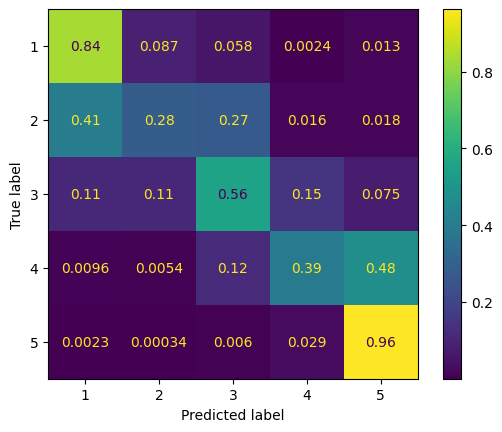

In [15]:
y_labels = test_output_obj['labels']
y_preds = test_output_obj['preds']
# Take the argmax of the predictions
y_preds = np.argmax(y_preds, axis=1)
# Convert to list
y_labels = y_labels.tolist()
y_preds = [int(pred+1) for pred in y_preds]
y_labels = [int(label+1) for label in y_labels]

# Calculate the accuracy
correct = 0
total = len(y_labels)
for i in range(total):
    if y_labels[i] == y_preds[i]:
        correct += 1
accuracy = correct / total
print('Accuracy:', accuracy)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_labels, y_preds, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,2,3,4,5])
disp.plot()

os.chdir("/new-stg/home/banghua/Amazon-Rating-Prediction/features_figures")
disp.figure_.savefig('BERT_cm.png',dpi=300)

# Get features (review rating, review time, review verified, review vote)

In [16]:
# Dataset with empty reviewText removed
train_dataset = [train_dataset[i] for i in range(len(train_dataset)) if i not in empty_train_indices]
val_dataset = [val_dataset[i] for i in range(len(val_dataset)) if i not in empty_val_indices]
test_dataset = [test_dataset[i] for i in range(len(test_dataset)) if i not in empty_test_indices]

# Get all labels from the test set
train_labels = [get_review_rating(train_dataset[i]) for i in range(len(train_dataset))]
val_labels = [get_review_rating(val_dataset[i]) for i in range(len(val_dataset))]
test_labels = [get_review_rating(test_dataset[i]) for i in range(len(test_dataset))]

train_times = [get_review_time(train_dataset[i]) for i in range(len(train_dataset))]
val_times = [get_review_time(val_dataset[i]) for i in range(len(val_dataset))]
test_times = [get_review_time(test_dataset[i]) for i in range(len(test_dataset))]

train_verified = [get_verified(train_dataset[i]) for i in range(len(train_dataset))]
val_verified = [get_verified(val_dataset[i]) for i in range(len(val_dataset))]
test_verified = [get_verified(test_dataset[i]) for i in range(len(test_dataset))]

train_vote = [get_vote(train_dataset[i]) for i in range(len(train_dataset))]
val_vote = [get_vote(val_dataset[i]) for i in range(len(val_dataset))]
test_vote = [get_vote(test_dataset[i]) for i in range(len(test_dataset))]

# Process review times

In [17]:
# Convert Unix timestamps to datetime objects
datetimes_train = unix_to_datetime(train_times)

# Find the median datetime
median_datetime_train = datetime.datetime.fromtimestamp(median(train_times))

# Calculate offsets
offsets_train = [calculate_offset(date, median_datetime_train) for date in datetimes_train]
offsets_val = [calculate_offset(date, median_datetime_train) for date in unix_to_datetime(val_times)]
offsets_test = [calculate_offset(date, median_datetime_train) for date in unix_to_datetime(test_times)]

# Verify the orders are consistent

In [18]:
for i in range(len(train_labels)):
    assert int(train_labels[i]-1) == train_output_obj["labels"][i]

for i in range(len(val_labels)):
    assert int(val_labels[i]-1) == valid_output_obj["labels"][i]

for i in range(len(test_labels)):
    assert int(test_labels[i]-1) == test_output_obj["labels"][i]

In [19]:
def get_features(entry_idx: int, dataset: str, include_time=True, include_text=True, include_verified=True, include_votes=True):
    features = []
    if dataset == "train":
        if include_time:
            features.append(np.float32(offsets_train[entry_idx]))
        if include_text:
            features.extend(train_output_obj["preds"][entry_idx])
        if include_verified:
            features.append(np.float32(train_verified[entry_idx]))
        if include_votes:
            vote = str(train_vote[entry_idx]).replace(',', '')
            features.append(np.float32(min(int(vote), 10)))
    elif dataset == "val":
        if include_time:
            features.append(np.float32(offsets_val[entry_idx]))
        if include_text:
            features.extend(valid_output_obj["preds"][entry_idx])
        if include_verified:
            features.append(np.float32(val_verified[entry_idx]))
        if include_votes:
            vote = str(val_vote[entry_idx]).replace(',', '')
            features.append(np.float32(min(int(vote), 10)))
    elif dataset == "test":
        if include_time:
            features.append(np.float32(offsets_test[entry_idx]))
        if include_text:
            features.extend(test_output_obj["preds"][entry_idx])
        if include_verified:
            features.append(np.float32(test_verified[entry_idx]))
        if include_votes:
            vote = str(test_vote[entry_idx]).replace(',', '')
            features.append(np.float32(min(int(vote), 10)))
    else:
        raise ValueError("Invalid dataset")
    return features

In [20]:
train_all_features = np.array([get_features(i, "train") for i in tqdm(range(len(train_dataset)))])
val_all_features = np.array([get_features(i, "val") for i in tqdm(range(len(val_dataset)))])
test_all_features = np.array([get_features(i, "test") for i in tqdm(range(len(test_dataset)))])

100%|█████████████████████████████| 1307734/1307734 [00:07<00:00, 172965.31it/s]


# Logistic Regression (Regression)

In [29]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

def round_y_preds(y_preds):
    return [min(5, max(1, round(y_pred))) for y_pred in y_preds]

def train_regression_model(include_scaler, train_features, train_labels, val_features, val_labels, test_features, test_labels, model_name, scaler=None):
    if include_scaler:
        if scaler is None:
            scaler = StandardScaler()
            scaler.fit(train_features)
        train_features = scaler.transform(train_features)
        val_features = scaler.transform(val_features)
        test_features = scaler.transform(test_features)
    if model_name == "linear":
        model = LinearRegression()
    elif model_name == "logistic":
        model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, class_weight="balanced")
    model.fit(train_features, train_labels)
    train_preds = model.predict(train_features)
    val_preds = model.predict(val_features)
    test_preds = model.predict(test_features)
    if model_name == "linear":
        train_mse = mean_squared_error(train_labels, train_preds)
        val_mse = mean_squared_error(val_labels, val_preds)
        test_mse = mean_squared_error(test_labels, test_preds)
        print(f"Training MSE: {train_mse}")
        print(f"Validation MSE: {val_mse}")
        print(f"Test MSE: {test_mse}")
        train_preds = round_y_preds(train_preds)
        val_preds = round_y_preds(val_preds)
        test_preds = round_y_preds(test_preds)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    test_acc = accuracy_score(test_labels, test_preds)
    print("--------------------")
    print(f"Training accuracy: {train_acc}")
    print(f"Validation accuracy: {val_acc}")
    print(f"Test accuracy: {test_acc}")
    print("--------------------")
    return model, scaler

def evaluate_linear_model(model, scaler, features, labels, model_type):
    if scaler is not None:
        features = scaler.transform(features)
    preds = model.predict(features)
    if model_type == "linear":
        mse = mean_squared_error(labels, preds)
        preds = round_y_preds(preds)
    else:
        mse = -1
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds, normalize="true")
    print(f"MSE: {mse}", f"Accuracy: {acc}")
    return mse, acc, cm

# Linear Regression & Logistic Regression (Full features)

Linear model without scaler
Training MSE: 0.3306249337996686
Validation MSE: 0.33061870677231386
Test MSE: 0.2915850567680883
--------------------
Training accuracy: 0.7384596796764239
Validation accuracy: 0.7385584132069629
Test accuracy: 0.7499070911974454
--------------------
MSE: 0.2915850567680883 Accuracy: 0.7499070911974454


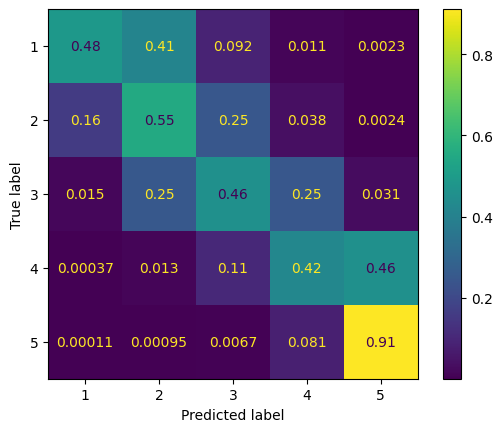

In [30]:
print("Linear model without scaler")
model_linear_no_scaler, _ = train_regression_model(False, train_all_features, train_labels, val_all_features, val_labels, test_all_features, test_labels, "linear")
mse_linear_no_scaler, acc_linear_no_scaler, cm_linear_no_scaler =\
    evaluate_linear_model(model_linear_no_scaler, _, test_all_features, test_labels, "linear")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_linear_no_scaler,display_labels=[1,2,3,4,5])
disp.plot()
disp.figure_.savefig('Linear_Full.png',dpi=300)


Logistic model without scaler
--------------------
Training accuracy: 0.7338134227578904
Validation accuracy: 0.7337082646745093
Test accuracy: 0.7473729366981359
--------------------
MSE: -1 Accuracy: 0.7473729366981359


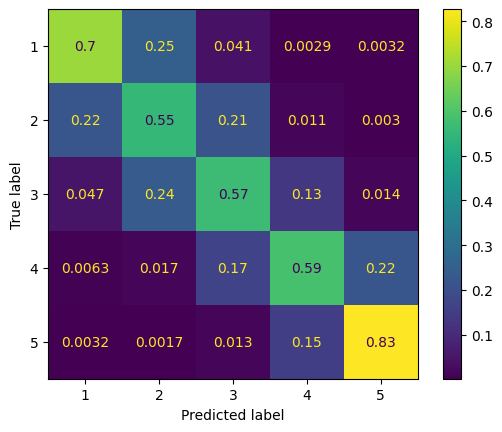

In [31]:
print("\nLogistic model without scaler")
model_logistic_no_scaler, _ = train_regression_model(False, train_all_features, train_labels, val_all_features, val_labels, test_all_features, test_labels, "logistic")
mse_logistic_no_scaler, acc_logistic_no_scaler, cm_logistic_no_scaler =\
    evaluate_linear_model(model_logistic_no_scaler, _, test_all_features, test_labels, "logistic")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_logistic_no_scaler,display_labels=[1,2,3,4,5])
disp.plot()
disp.figure_.savefig('Logistic_Full.png',dpi=300)

# Linear Regression & Logistic Regression (NO Text)

  0%|                                               | 0/3923158 [00:00<?, ?it/s]

100%|█████████████████████████████| 1307734/1307734 [00:09<00:00, 132264.11it/s]


Linear Model without text features
Training MSE: 1.7886272094227482
Validation MSE: 1.7886351665692464
Test MSE: 1.7881832017971495
--------------------
Training accuracy: 0.12914697802127775
Validation accuracy: 0.1286157234123085
Test accuracy: 0.12928546631042703
--------------------
MSE: 1.7881832017971495 Accuracy: 0.12928546631042703
\Logistic Model without text features
--------------------
Training accuracy: 0.3844599172401417
Validation accuracy: 0.384554154129661
Test accuracy: 0.3838808197997452
--------------------
MSE: -1 Accuracy: 0.3838808197997452


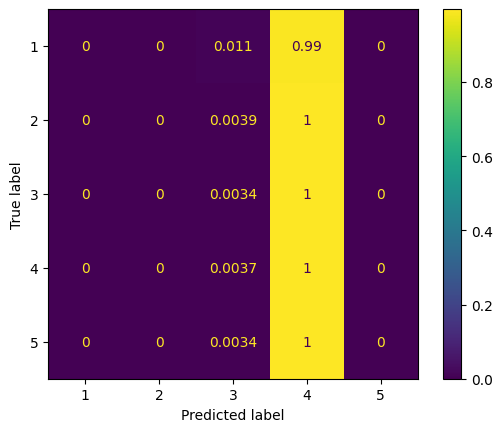

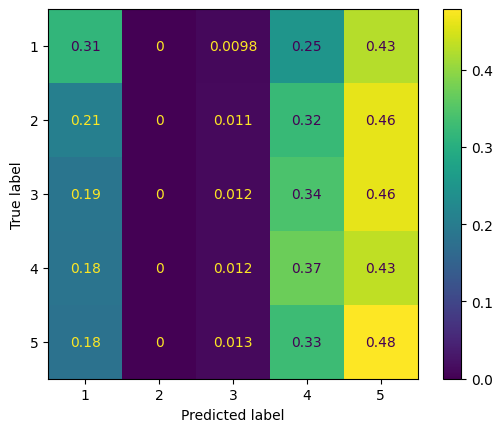

In [32]:
train_wo_text = np.array([get_features(i, "train", include_text=False) for i in tqdm(range(len(train_dataset)))])
val_wo_text = np.array([get_features(i, "val", include_text=False) for i in tqdm(range(len(val_dataset)))])
test_wo_text = np.array([get_features(i, "test", include_text=False) for i in tqdm(range(len(test_dataset)))])

print("Linear Model without text features")
model_linear_no_text, _ = train_regression_model(False, train_wo_text, train_labels, val_wo_text, val_labels, test_wo_text, test_labels, "linear")
mse_linear_no_text, acc_linear_no_text, cm_linear_no_text =\
    evaluate_linear_model(model_linear_no_text, _, test_wo_text, test_labels, "linear")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_linear_no_text,display_labels=[1,2,3,4,5])
disp.plot()
disp.figure_.savefig('Linear_NO_Text.png',dpi=300)

print("\Logistic Model without text features")
model_logistic_no_text, _ = train_regression_model(False, train_wo_text, train_labels, val_wo_text, val_labels, test_wo_text, test_labels, "logistic")
mse_logistic_no_text, acc_logistic_no_text, cm_logistic_no_text =\
    evaluate_linear_model(model_logistic_no_text, _, test_wo_text, test_labels, "logistic")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_logistic_no_text,display_labels=[1,2,3,4,5])
disp.plot()
disp.figure_.savefig('Logistic_NO_Text.png',dpi=300)

# Linear Regression & Logistic Regression (NO Time)

In [14]:
train_wo_time = np.array([get_features(i, "train", include_time=False) for i in tqdm(range(len(train_dataset)))])
val_wo_time = np.array([get_features(i, "val", include_time=False) for i in tqdm(range(len(val_dataset)))])
test_wo_time = np.array([get_features(i, "test", include_time=False) for i in tqdm(range(len(test_dataset)))])

print("Linear Model without time features")
model_linear_no_time, _ = train_regression_model(False, train_wo_time, train_labels, val_wo_time, val_labels, test_wo_time, test_labels, "linear")
mse_linear_no_time, acc_linear_no_time, cm_linear_no_time =\
    evaluate_linear_model(model_linear_no_time, _, test_wo_time, test_labels, "linear")

print("\nLogistic Model without time features")
model_logistic_no_time, _ = train_regression_model(False, train_wo_time, train_labels, val_wo_time, val_labels, test_wo_time, test_labels, "logistic")
mse_logistic_no_time, acc_logistic_no_time, cm_logistic_no_time =\
    evaluate_linear_model(model_logistic_no_time, _, test_wo_time, test_labels, "logistic")

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1307734/1307734 [00:03<00:00, 421325.82it/s]


Linear Model without time features
Training MSE: 0.330719028480175
Validation MSE: 0.33072174006274396
Test MSE: 0.29168967942794477
--------------------
Training accuracy: 0.7383740343876031
Validation accuracy: 0.7384383638108419
Test accuracy: 0.7498558575367773
--------------------
MSE: 0.29168967942794477 Accuracy: 0.7498558575367773

Logistic Model without time features
--------------------
Training accuracy: 0.7943733084418216
Validation accuracy: 0.7944876681742934
Test accuracy: 0.8065676964887355
--------------------
MSE: -1 Accuracy: 0.8065676964887355


# Linear Regression & Logistic Regression (NO Verified)

In [15]:
train_wo_verified = np.array([get_features(i, "train", include_verified=False) for i in tqdm(range(len(train_dataset)))])
val_wo_verified = np.array([get_features(i, "val", include_verified=False) for i in tqdm(range(len(val_dataset)))])
test_wo_verified = np.array([get_features(i, "test", include_verified=False) for i in tqdm(range(len(test_dataset)))])

print("Linear Model without verified features")
model_linear_no_verified, _ = train_regression_model(False, train_wo_verified, train_labels, val_wo_verified, val_labels, test_wo_verified, test_labels, "linear")
mse_linear_no_verified, acc_linear_no_verified, cm_linear_no_verified =\
    evaluate_linear_model(model_linear_no_verified, _, test_wo_verified, test_labels, "linear")

print("\nLogistic Model without verified features")
model_logistic_no_verified, _ = train_regression_model(False, train_wo_verified, train_labels, val_wo_verified, val_labels, test_wo_verified, test_labels, "logistic")
mse_logistic_no_verified, acc_logistic_no_verified, cm_logistic_no_verified =\
    evaluate_linear_model(model_logistic_no_verified, _, test_wo_verified, test_labels, "logistic")

  0%|                                                                                                                  | 0/3923158 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1307734/1307734 [00:10<00:00, 120633.08it/s]


Linear Model without verified features
Training MSE: 0.33078270959805434
Validation MSE: 0.33075959327001137
Test MSE: 0.29169251833932586
--------------------
Training accuracy: 0.7385567953164262
Validation accuracy: 0.7386325838529739
Test accuracy: 0.749974383169666
--------------------
MSE: 0.29169251833932586 Accuracy: 0.749974383169666

Logistic Model without verified features
--------------------
Training accuracy: 0.794406954805287
Validation accuracy: 0.794527429757722
Test accuracy: 0.8066411059129762
--------------------
MSE: -1 Accuracy: 0.8066411059129762


# Linear Regression & Logistic Regression (NO Vote)

In [16]:
train_wo_votes = np.array([get_features(i, "train", include_votes=False) for i in tqdm(range(len(train_dataset)))])
val_wo_votes = np.array([get_features(i, "val", include_votes=False) for i in tqdm(range(len(val_dataset)))])
test_wo_votes = np.array([get_features(i, "test", include_votes=False) for i in tqdm(range(len(test_dataset)))])

print("Linear Model without votes features")
model_linear_no_votes, _ = train_regression_model(False, train_wo_votes, train_labels, val_wo_votes, val_labels, test_wo_votes, test_labels, "linear")
mse_linear_no_votes, acc_linear_no_votes, cm_linear_no_votes =\
    evaluate_linear_model(model_linear_no_votes, _, test_wo_votes, test_labels, "linear")

print("\nLogistic Model without votes features")
model_logistic_no_votes, _ = train_regression_model(False, train_wo_votes, train_labels, val_wo_votes, val_labels, test_wo_votes, test_labels, "logistic")
mse_logistic_no_votes, acc_logistic_no_votes, cm_logistic_no_votes =\
    evaluate_linear_model(model_logistic_no_votes, _, test_wo_votes, test_labels, "logistic")

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1307734/1307734 [00:06<00:00, 200643.29it/s]


Linear Model without votes features
Training MSE: 0.3308882060345776
Validation MSE: 0.3308626663495693
Test MSE: 0.29174843472599965
--------------------
Training accuracy: 0.7385746380849305
Validation accuracy: 0.7387832190825014
Test accuracy: 0.7500409104603841
--------------------
MSE: 0.29174843472599965 Accuracy: 0.7500409104603841

Logistic Model without votes features
--------------------
Training accuracy: 0.7939603757992924
Validation accuracy: 0.79410228667337
Test accuracy: 0.806211354908567
--------------------
MSE: -1 Accuracy: 0.806211354908567


# Simple Neural Network

In [33]:
# Simple Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from balanced_loss import Loss

train_labels_nn = [int(label-1) for label in train_labels]
val_labels_nn = [int(label-1) for label in val_labels]
test_labels_nn = [int(label-1) for label in test_labels]

# Samples per class
samples_per_class = [0] * 5
for entry in train_labels_nn:
    samples_per_class[entry] += 1

# Focal Loss
focal_loss = Loss(
    loss_type="focal_loss",
    samples_per_class=samples_per_class,
    class_balanced=True
)

/new-stg/home/banghua/anaconda3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_nn_model(train_features, train_labels, val_features, val_labels, test_features, test_labels):
    model = SimpleNN(train_features.shape[1], 100, 5).cuda()
    criterion = focal_loss
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    train_features = torch.from_numpy(train_features).cuda()
    train_labels = torch.from_numpy(np.array(train_labels)).cuda()
    val_features = torch.from_numpy(val_features).cuda()
    val_labels = torch.from_numpy(np.array(val_labels)).cuda()
    test_features = torch.from_numpy(test_features).cuda()
    test_labels = torch.from_numpy(np.array(test_labels)).cuda()
    train_dataset = TensorDataset(train_features, train_labels)
    val_dataset = TensorDataset(val_features, val_labels)
    test_dataset = TensorDataset(test_features, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

    for epoch in range(10):
        model.train()
        train_loss = 0
        train_preds, train_targets = [], []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data.float())
            preds = output.argmax(dim=1).cpu().tolist()
            train_preds.extend(preds)
            train_targets.extend(target.cpu().tolist())
            loss = criterion(output, target.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_targets, train_preds)
        print(f"Epoch: {epoch}, Training Loss: {train_loss}", f"Training Accuracy: {train_acc}")
        model.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        for batch_idx, (data, target) in enumerate(val_loader):
            output = model(data.float())
            preds = output.argmax(dim=1).cpu().tolist()
            val_preds.extend(preds)
            val_targets.extend(target.cpu().tolist())
            loss = criterion(output, target.long())
            val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f"Epoch: {epoch}, Validation Loss: {val_loss}")
        val_acc = accuracy_score(val_targets, val_preds)
        print(f"Epoch: {epoch}, Validation Accuracy: {val_acc}")
    model.eval()
    test_loss = 0
    test_preds, test_targets = [], []
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data.float())
        loss = criterion(output, target.long())
        test_loss += loss.item()
        test_preds.extend(output.argmax(dim=1).tolist())
        test_targets.extend(target.tolist())
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss}")
    test_acc = accuracy_score(test_targets, test_preds)
    print(f"Test Accuracy: {test_acc}")
    cm = confusion_matrix(test_targets, test_preds, normalize="true")
    return model, cm

# Simple NN with all features

In [37]:
simple_nn_model_all, cm_nn_model_all = train_nn_model(train_all_features, train_labels_nn, val_all_features, val_labels_nn, test_all_features, test_labels_nn)

Epoch: 0, Training Loss: 0.2637944978920428 Training Accuracy: 0.7859125225137504
Epoch: 0, Validation Loss: 0.2469672442461963
Epoch: 0, Validation Accuracy: 0.7948661678627001
Epoch: 1, Training Loss: 0.24714815084645544 Training Accuracy: 0.7947604965183661
Epoch: 1, Validation Loss: 0.24687649575477474
Epoch: 1, Validation Accuracy: 0.7945037257368318
Epoch: 2, Training Loss: 0.24702632839408448 Training Accuracy: 0.7947775745967917
Epoch: 2, Validation Loss: 0.24667706397684153
Epoch: 2, Validation Accuracy: 0.7947889386333485
Epoch: 3, Training Loss: 0.24698145429376273 Training Accuracy: 0.7947503006506493
Epoch: 3, Validation Loss: 0.2467125176870394
Epoch: 3, Validation Accuracy: 0.7947759396541507
Epoch: 4, Training Loss: 0.24693318276757487 Training Accuracy: 0.7948614356087621
Epoch: 4, Validation Loss: 0.24672464923772827
Epoch: 4, Validation Accuracy: 0.7948715203835464
Epoch: 5, Training Loss: 0.2469041797804932 Training Accuracy: 0.7948191227577375
Epoch: 5, Validation 

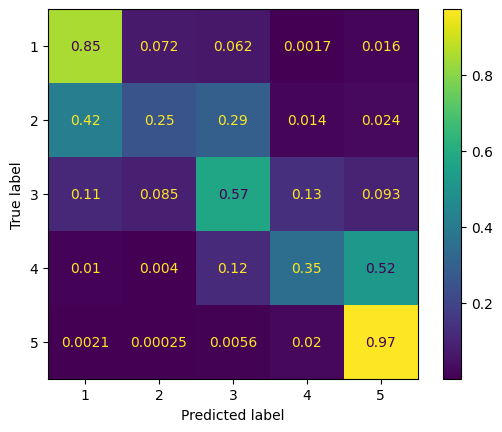

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn_model_all,display_labels=[1,2,3,4,5])
disp.plot()
disp.figure_.savefig('SimpleNN_Full.png',dpi=300)

# Simple NN with no text

In [20]:
simple_nn_model_no_text = train_nn_model(train_wo_text, train_labels_nn, val_wo_text, val_labels_nn, test_wo_text, test_labels_nn)

Epoch: 0, Training Loss: 0.5012048946417448 Training Accuracy: 0.6262979976845184
Epoch: 0, Validation Loss: 0.48758292170197753
Epoch: 0, Validation Accuracy: 0.6375074075065281
Epoch: 1, Training Loss: 0.4881211643988006 Training Accuracy: 0.6365224138308985
Epoch: 1, Validation Loss: 0.4874825818531204
Epoch: 1, Validation Accuracy: 0.6375097014440336
Epoch: 2, Training Loss: 0.48807044081498785 Training Accuracy: 0.6365326096986152
Epoch: 2, Validation Loss: 0.48735783352911566
Epoch: 2, Validation Accuracy: 0.6375127600273743
Epoch: 3, Training Loss: 0.48804140798669765 Training Accuracy: 0.636527256868064
Epoch: 3, Validation Loss: 0.4873656596003191
Epoch: 3, Validation Accuracy: 0.637524994360737
Epoch: 4, Training Loss: 0.4880201875354651 Training Accuracy: 0.6365320999052294
Epoch: 4, Validation Loss: 0.48738639655993765
Epoch: 4, Validation Accuracy: 0.6375158186107149
Epoch: 5, Training Loss: 0.4880137402012104 Training Accuracy: 0.6365236883143631
Epoch: 5, Validation Loss

# Simple NN with no time

In [21]:
simple_nn_model_no_time = train_nn_model(train_wo_time, train_labels_nn, val_wo_time, val_labels_nn, test_wo_time, test_labels_nn)

Epoch: 0, Training Loss: 0.2627308750777877 Training Accuracy: 0.7832921845105397
Epoch: 0, Validation Loss: 0.24738906156009352
Epoch: 0, Validation Accuracy: 0.794569485278656
Epoch: 1, Training Loss: 0.24765096053418884 Training Accuracy: 0.7945662652383615
Epoch: 1, Validation Loss: 0.24717924287994517
Epoch: 1, Validation Accuracy: 0.7947071215289858
Epoch: 2, Training Loss: 0.24756695194819278 Training Accuracy: 0.7945892059407242
Epoch: 2, Validation Loss: 0.2472921999547403
Epoch: 2, Validation Accuracy: 0.7946696538830628
Epoch: 3, Training Loss: 0.24751859606245613 Training Accuracy: 0.7946587927378913
Epoch: 3, Validation Loss: 0.247065265693575
Epoch: 3, Validation Accuracy: 0.7948256416334364
Epoch: 4, Training Loss: 0.24748712718206806 Training Accuracy: 0.7946019507753702
Epoch: 4, Validation Loss: 0.24700903759595932
Epoch: 4, Validation Accuracy: 0.7948661678627001
Epoch: 5, Training Loss: 0.2474419282659857 Training Accuracy: 0.7946740865394665
Epoch: 5, Validation Lo

# Simple NN with no verified

In [22]:
simple_nn_model_no_verified = train_nn_model(train_wo_verified, train_labels_nn, val_wo_verified, val_labels_nn, test_wo_verified, test_labels_nn)

Epoch: 0, Training Loss: 0.25906937736590124 Training Accuracy: 0.7850642263197148
Epoch: 0, Validation Loss: 0.2469348023661612
Epoch: 0, Validation Accuracy: 0.7946994750706342
Epoch: 1, Training Loss: 0.2472291721851567 Training Accuracy: 0.7945670299284403
Epoch: 1, Validation Loss: 0.24679241901925286
Epoch: 1, Validation Accuracy: 0.7947644699666232
Epoch: 2, Training Loss: 0.2471121877105226 Training Accuracy: 0.7946952429649787
Epoch: 2, Validation Loss: 0.2465952974576532
Epoch: 2, Validation Accuracy: 0.7948967536961068
Epoch: 3, Training Loss: 0.24705765156818082 Training Accuracy: 0.7947095171797822
Epoch: 3, Validation Loss: 0.2468268869675008
Epoch: 3, Validation Accuracy: 0.7946773003414144
Epoch: 4, Training Loss: 0.24701350507382808 Training Accuracy: 0.7947541241010431
Epoch: 4, Validation Loss: 0.2467491839646547
Epoch: 4, Validation Accuracy: 0.79488834259192
Epoch: 5, Training Loss: 0.24698558249870523 Training Accuracy: 0.7947100269731681
Epoch: 5, Validation Loss

# Simple NN with no vote

In [23]:
simple_nn_model_no_votes = train_nn_model(train_wo_votes, train_labels_nn, val_wo_votes, val_labels_nn, test_wo_votes, test_labels_nn)

Epoch: 0, Training Loss: 0.26348079937764896 Training Accuracy: 0.7817900782991661
Epoch: 0, Validation Loss: 0.2472878354535976
Epoch: 0, Validation Accuracy: 0.7942812137987988
Epoch: 1, Training Loss: 0.24753823735613165 Training Accuracy: 0.7941436465215013
Epoch: 1, Validation Loss: 0.2470808015183104
Epoch: 1, Validation Accuracy: 0.7943767945281944
Epoch: 2, Training Loss: 0.2474189386829454 Training Accuracy: 0.7942876631530007
Epoch: 2, Validation Loss: 0.24707672291425098
Epoch: 2, Validation Accuracy: 0.7943393268822713
Epoch: 3, Training Loss: 0.247389681979485 Training Accuracy: 0.7942160371822904
Epoch: 3, Validation Loss: 0.24693435444518433
Epoch: 3, Validation Accuracy: 0.7944372015491724
Epoch: 4, Training Loss: 0.24734345519436923 Training Accuracy: 0.7942970943306388
Epoch: 4, Validation Loss: 0.24693187068512368
Epoch: 4, Validation Accuracy: 0.7943592076739856
Epoch: 5, Training Loss: 0.24732267983366651 Training Accuracy: 0.7942117039385108
Epoch: 5, Validation L

# Confusion Matrix

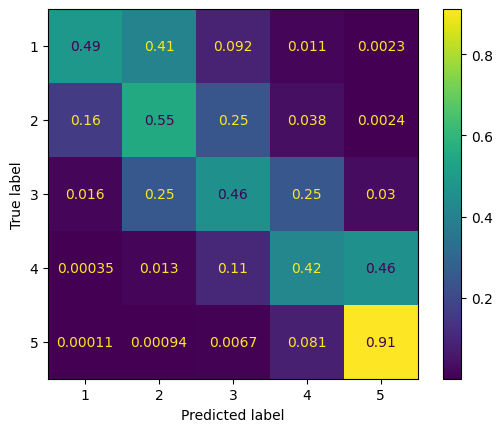

In [123]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, y_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,2,3,4,5])
disp.plot()